# image reconstruction

## Import libraries

In [241]:
import torch
import torchvision
from torch.utils.data import Dataset
from os import listdir
from os.path import join
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from math import log10
from tqdm import tqdm
import os
import math

## Load data

In [242]:
directory_data  = './'
filename_data   = 'assignment_11_data.npz'
data            = np.load(os.path.join(directory_data, filename_data))

clean_image_train = data['label_train']
input_image_test  = data['input_test'] 
clean_image_test  = data['label_test']

In [243]:
print(clean_image_train.shape)
print(input_image_test.shape)
print(clean_image_test.shape)

(800, 128, 128)
(400, 128, 128)
(400, 128, 128)


## plot data

In [244]:
def plot_image(title, image):
    
    nRow = 6
    nCol = 4
    size = 3
    
    fig, axes = plt.subplots(nRow, nCol, figsize=(size * nCol, size * nRow))
    fig.suptitle(title, fontsize=16)

    for r in range(nRow):
        for c in range(nCol):
            k = r * nCol * 10 + c * 4 + 10
            axes[r, c].imshow(image[k], cmap='gray', vmin=0, vmax=1)

    plt.tight_layout()
    plt.show()

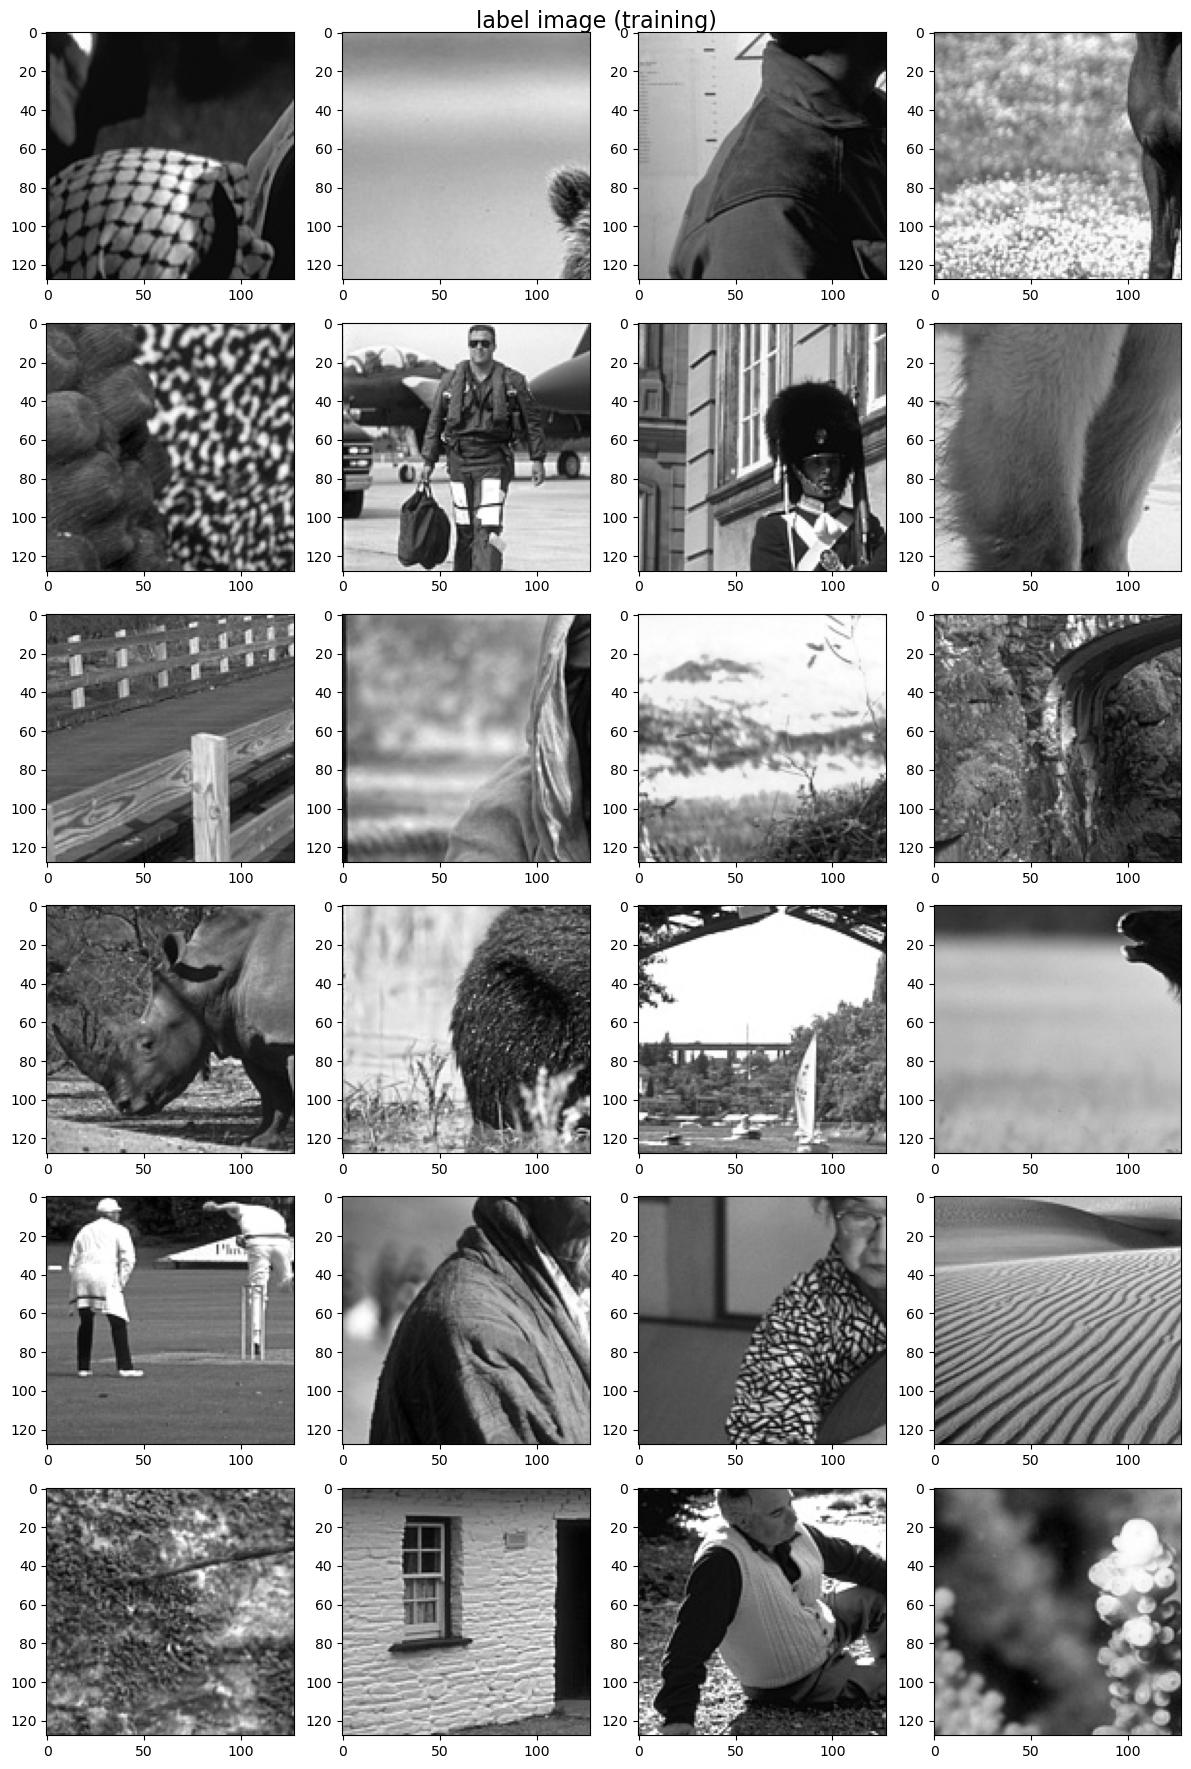

In [245]:
plot_image('label image (training)', clean_image_train)

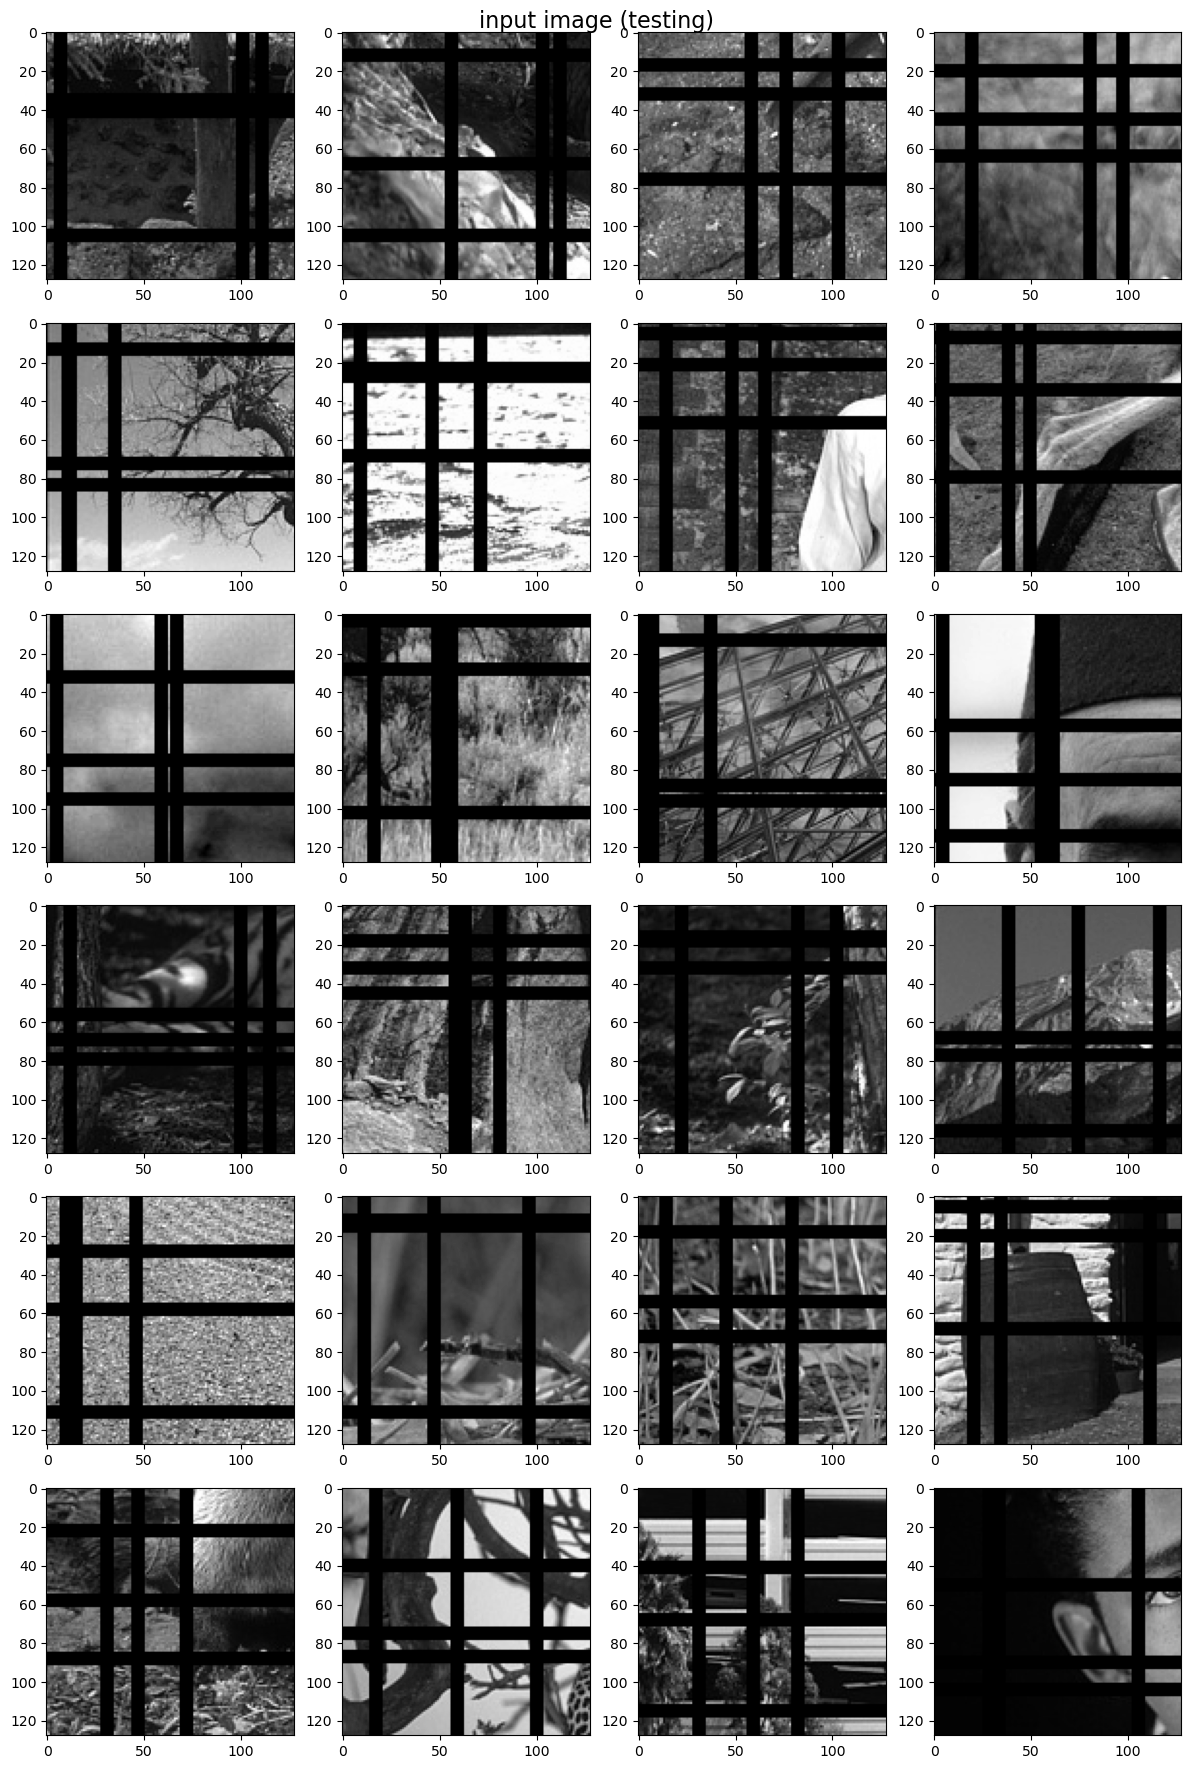

In [246]:
plot_image('input image (testing)', input_image_test)

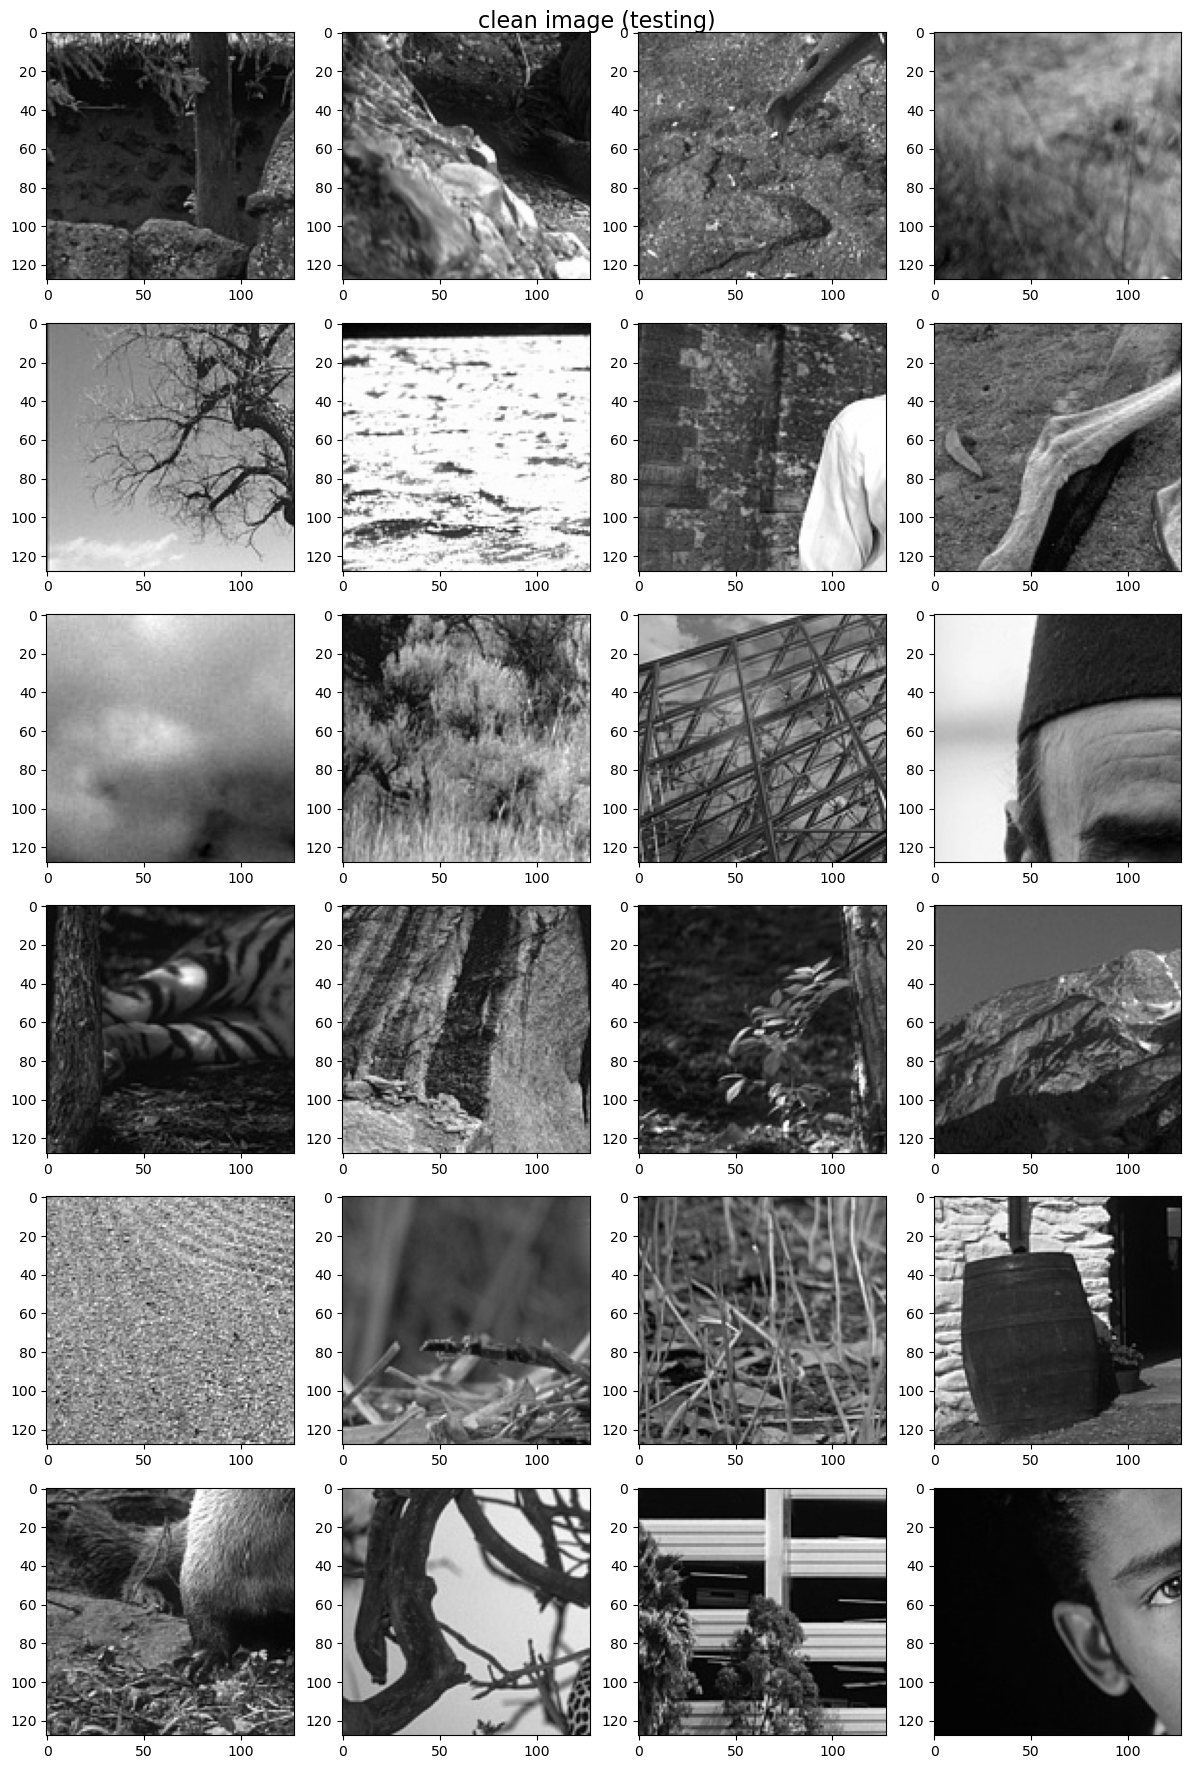

In [247]:
plot_image('clean image (testing)', clean_image_test)

## custom data loader for the training data

In [248]:
class dataset(Dataset):
    
    def __init__(self, clean_image):
        
        self.clean_image = clean_image

    def __getitem__(self, index):
        # ==================================================
        # modify the codes for training data
        #        
        clean_image = self.clean_image[index]
        degrade_image = self.clean_image[index]

        height, width = degrade_image.shape

        seed = np.random.randint(1, 11)
        height_ = height//13

        for j in range( height_*seed, height_*(seed+1)):
            for i in range(width):
                degrade_image[j,i] = 0

        # for j in range( height_*seed, height_*(seed+1)):
        #     for i in range(width):
        #         degrade_image[j,i] = 0

        # for j in range( height):
        #     for i in range(width_*seed, width_*(seed+1)):
        #         degrade_image[j,i] = 0

        # for j in range( height):
        #     for i in range(width_*seed, width_*(seed+1)):
        #         degrade_image[j,i] = 0
        
        
        # if seed == 1:
        #     trans = transforms.Compose([transforms.RandomHorizontalFlip(),])
        #     image   = trans(image)
        #     mask    = trans(mask)



        clean_image = torch.FloatTensor(clean_image).unsqueeze(dim=0)
        degrade_image = torch.FloatTensor(degrade_image).unsqueeze(dim=0)
        
        # transform = transforms.Compose([ transforms.ToTensor(), transforms.RandomErasing(p=1, scale=(0.02, 0.33), ratio=(0.3, 3.3), value=0), transforms.ConvertImageDtype(torch.float), ])
        transform = transforms.Compose([
            # transforms.PILToTensor(),
            # transforms.ConvertImageDtype(torch.float),
            transforms.RandomErasing(p=1, scale=(0.02, 0.15), ratio=(0.3, 1.8), value=0)
        ])
        
        degrade_image = transform(degrade_image)

        temp = np.random.randint(0, 360)
        clean_image = transforms.functional.rotate(clean_image, temp)
        degrade_image = transforms.functional.rotate(degrade_image, temp)


        return (clean_image, degrade_image)
        #    
        # ==================================================

    def __len__(self):

        number_image = self.clean_image.shape[0]

        return number_image    

## setting device

In [249]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [250]:
print(device)

cpu


## custom data loader for the testing data

In [251]:
input_image_test = torch.FloatTensor(input_image_test).unsqueeze(dim=1)
clean_image_test = torch.FloatTensor(clean_image_test).unsqueeze(dim=1)

input_image_test = input_image_test.to(device)
clean_image_test = clean_image_test.to(device)

## construct datasets and dataloaders for training and testing

In [252]:
# ==================================================
# determine the mini-batch size
#
size_minibatch      = 10
#
# ==================================================

dataset_train       = dataset(clean_image_train)
dataloader_train    = torch.utils.data.DataLoader(dataset_train, batch_size=size_minibatch, shuffle=True, drop_last=True)

## construct a neural network 

In [253]:
class Network(nn.Module): 

	def __init__(self):
        
		super(Network, self).__init__()
		
		self.conv2d_encoder1	= nn.Conv2d(1 , 8, kernel_size=3, stride=1, padding=1, bias=True)
		nn.init.kaiming_uniform_(self.conv2d_encoder1.weight, a=math.sqrt(7))	
		self.conv2d_batch1			= nn.BatchNorm2d(8)

		self.conv2d_encoder2	= nn.Conv2d(8, 16, kernel_size=3, stride=1, padding=1, bias=True)
		nn.init.kaiming_uniform_(self.conv2d_encoder2.weight, a=math.sqrt(7))	
		self.conv2d_batch2			= nn.BatchNorm2d(16)

		self.conv2d_encoder3	= nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1, bias=True)	
		nn.init.kaiming_uniform_(self.conv2d_encoder3.weight, a=math.sqrt(7))	
		self.conv2d_batch3			= nn.BatchNorm2d(32)

		self.conv2d_encoder4	= nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1, bias=True)	
		nn.init.kaiming_uniform_(self.conv2d_encoder4.weight, a=math.sqrt(7))	
		self.conv2d_batch4			= nn.BatchNorm2d(64)

		self.conv2d_encoder5	= nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1, bias=True)	
		nn.init.kaiming_uniform_(self.conv2d_encoder5.weight, a=math.sqrt(7))	
		self.conv2d_batch5			= nn.BatchNorm2d(128)

		self.conv2d_decoder5 	= nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1, bias=True)
		nn.init.kaiming_uniform_(self.conv2d_decoder5.weight, a=math.sqrt(7))

		self.conv2d_decoder4 	= nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=1, bias=True)
		nn.init.kaiming_uniform_(self.conv2d_decoder4.weight, a=math.sqrt(7))

		self.conv2d_decoder3 	= nn.Conv2d(32, 16, kernel_size=3, stride=1, padding=1, bias=True)
		nn.init.kaiming_uniform_(self.conv2d_decoder3.weight, a=math.sqrt(7))

		self.conv2d_decoder2 	= nn.Conv2d(16, 8, kernel_size=3, stride=1, padding=1, bias=True)
		nn.init.kaiming_uniform_(self.conv2d_decoder2.weight, a=math.sqrt(7))	

		self.conv2d_decoder1 	= nn.Conv2d(8, 1, kernel_size=1, stride=1, padding=0, bias=True)
		nn.init.kaiming_uniform_(self.conv2d_decoder1.weight, a=math.sqrt(7))
		self.upsample_2d			= nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)
		self.encoder_pooling	= nn.MaxPool2d(2,2)
		self.activation			= nn.ReLU(inplace=True)
		self.out	            = nn.Sigmoid()

		
	def forward(self, x):
																																		
		enc1  = self.conv2d_encoder1(x)																										
		enc1	= self.encoder_pooling(enc1)																												
		batch1 = self.conv2d_batch1(enc1)																					
		act1  = self.activation(batch1)																									
		enc2  = self.conv2d_encoder2(act1)																									
		enc2	= self.encoder_pooling(enc2)																											
		batch2 = self.conv2d_batch2(enc2)																												
		act2  = self.activation(batch2)																									
		enc3  = self.conv2d_encoder3(act2)																									
		batch3 = self.conv2d_batch3(enc3)																												
		act3  = self.activation(batch3)																								
		enc4  = self.conv2d_encoder4(act3)																									
		batch4 = self.conv2d_batch4(enc4)																													
		act4  = self.activation(batch4)																								
		enc5  = self.conv2d_encoder5(act4)																									
		batch5 = self.conv2d_batch5(enc5)																										
		act5  = self.activation(batch5)																									
		
		dec5  = self.conv2d_decoder5(act5) 																								
		_batch5 = self.conv2d_batch4(dec5+enc4)																										
		_act4  = self.activation(_batch5)																									
		dec4  = self.conv2d_decoder4(_act4) 																								
		_batch4 = self.conv2d_batch3(dec4+enc3)																											
		_act3  = self.activation(_batch4)																									
		dec3  = self.upsample_2d(_act3)		
		dec3  = self.conv2d_decoder3(dec3) 																								
		_batch3 = self.conv2d_batch2(dec3)																													
		_act2  = self.activation(_batch3)																									
		dec2  = self.upsample_2d(_act2)		
		dec2  = self.conv2d_decoder2(dec2) 																								
		_batch2 = self.conv2d_batch1(dec2)																													
		_act1  = self.activation(_batch2)																						
		dec1  = self.conv2d_decoder1(_act1)		
		out = self.out(dec1)																										

		return out


## build the network

In [254]:
model = Network().to(device)

# ==================================================
# determine the optimiser and its associated hyper-parameters
#
learning_rate   = 0.01
number_epoch    = 20

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=1e-5)
# optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
#
# ==================================================

## compute the prediction

In [255]:
def compute_prediction(model, input):

    prediction = model(input)

    return prediction

## compute the PSNR metric

- data1 : mini-batch-size x channel x height x width (torch tensor)
- data2 : mini-batch-size x channel x height x width (torch tensor)

In [256]:
def compute_psnr(data1, data2):

    mse         = nn.MSELoss()(data1, data2)
    mse_value   = mse.item()
    psnr        = 10 * np.log10(1 / mse_value)

    return psnr

## Variable for the learning curves

In [257]:
psnr_test = np.zeros(number_epoch)

## train

In [258]:
def train(model, optimizer, dataloader):

    model.train()

    # ==================================================
    # fill up the blank
    #

    for index_batch, (clean_image, degrade_image) in enumerate(dataloader):

        clean_image    = clean_image.to(device)
        degrade_image  = degrade_image.to(device)
        
        prediction  = compute_prediction(model, degrade_image)
        # psnr    = compute_psnr(prediction, clean_image)
        loss = nn.MSELoss()(prediction, clean_image)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


    #
    # ==================================================

## test

In [259]:
def test(model, input_image, clean_image):

    model.eval()

    num_steps   = 40
    steps       = np.linspace(0, input_image.shape[0], num_steps+1).astype(int)
    psnr_steps  = np.zeros(num_steps)
    
    for i in range(num_steps):
        input           = input_image[steps[i]:steps[i+1], :, :, :]
        clean           = clean_image[steps[i]:steps[i+1], :, :, :]
        prediction      = compute_prediction(model, input)
        psnr_steps[i]   = compute_psnr(clean, prediction)
    
    psnr = psnr_steps.mean()
    
    return psnr

## train and test

In [260]:
# ================================================================================
# 
# iterations for epochs
#
# ================================================================================
for i in tqdm(range(number_epoch)):
    
    # ================================================================================
    # 
    # training
    #
    # ================================================================================
    train(model, optimizer, dataloader_train)

    # ================================================================================
    # 
    # testing
    #
    # ================================================================================
    psnr            = test(model, input_image_test, clean_image_test)
    psnr_test[i]    = psnr

100%|██████████| 20/20 [07:51<00:00, 23.57s/it]


---

## functions for presenting the results

---

In [261]:
def function_result_01():
    
    title           = 'psnr (testing)'
    label_axis_x    = 'epoch' 
    label_axis_y    = 'psnr'
    
    plt.figure(figsize=(8, 6))
    plt.title(title)

    plt.plot(psnr_test, '-')
    
    plt.xlabel(label_axis_x)
    plt.ylabel(label_axis_y)

    plt.tight_layout()
    plt.show()

In [262]:
def function_result_02():
   
    nRow = 9
    nCol = 4
    size = 3
   
    title = 'testing results'
    fig, axes = plt.subplots(nRow, nCol, figsize=(size * nCol, size * nRow))
    fig.suptitle(title, fontsize=16)

    model.eval()

    num_test = 12

    input_image         = input_image_test[0:num_test]
    clean_image         = clean_image_test[0:num_test]
    prediction_image    = compute_prediction(model, input_image)
   
    input_image         = input_image.detach().cpu().squeeze(axis=1)
    clean_image         = clean_image.detach().cpu().squeeze(axis=1)
    prediction_image    = prediction_image.detach().cpu().squeeze(axis=1)

    nStep   = 3
    t       = 0
   
    for r in range(3):
        for c in range(nCol):
            k = r * nCol * 10 + c * 4 + 10
           
            input       = input_image[t].detach().cpu().squeeze(axis=1)
            clean       = clean_image[t].detach().cpu().squeeze(axis=1)
            prediction  = prediction_image[t].detach().cpu().squeeze(axis=1)
           
            axes[0 + r * nStep, c].imshow(input, cmap='gray')
            axes[1 + r * nStep, c].imshow(clean, cmap='gray', vmin=0, vmax=1)
            axes[2 + r * nStep, c].imshow(prediction, cmap='gray', vmin=0, vmax=1)

            axes[0 + r * nStep, c].xaxis.set_visible(False)
            axes[1 + r * nStep, c].xaxis.set_visible(False)
            axes[2 + r * nStep, c].xaxis.set_visible(False)
           
            axes[0 + r * nStep, c].yaxis.set_visible(False)
            axes[1 + r * nStep, c].yaxis.set_visible(False)
            axes[2 + r * nStep, c].yaxis.set_visible(False)
           
            t = t + 1
   
    plt.tight_layout()
    plt.show()

In [263]:
def function_result_03():
    
    print('final testing psnr = %9.8f' % (psnr_test[-1]))

---

## results 

---


################################################################################
#
# RESULT # 01
#
################################################################################



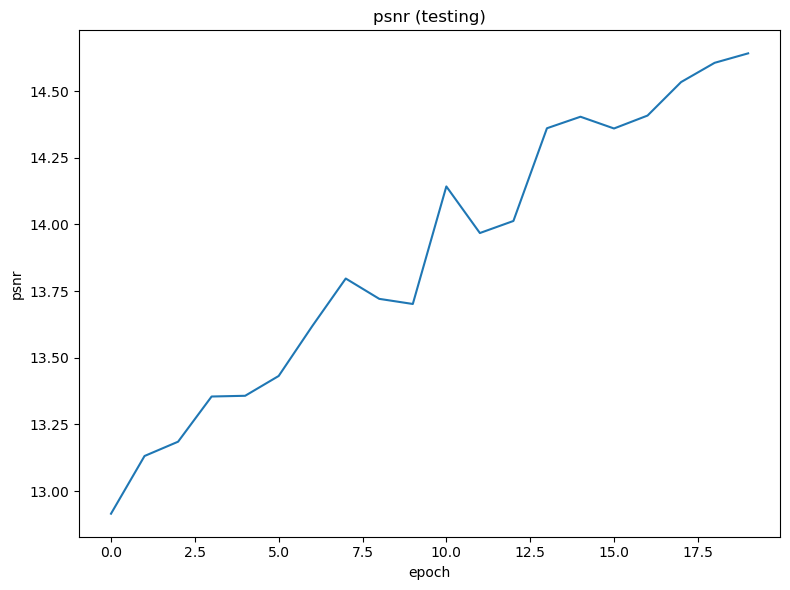


################################################################################
#
# RESULT # 02
#
################################################################################



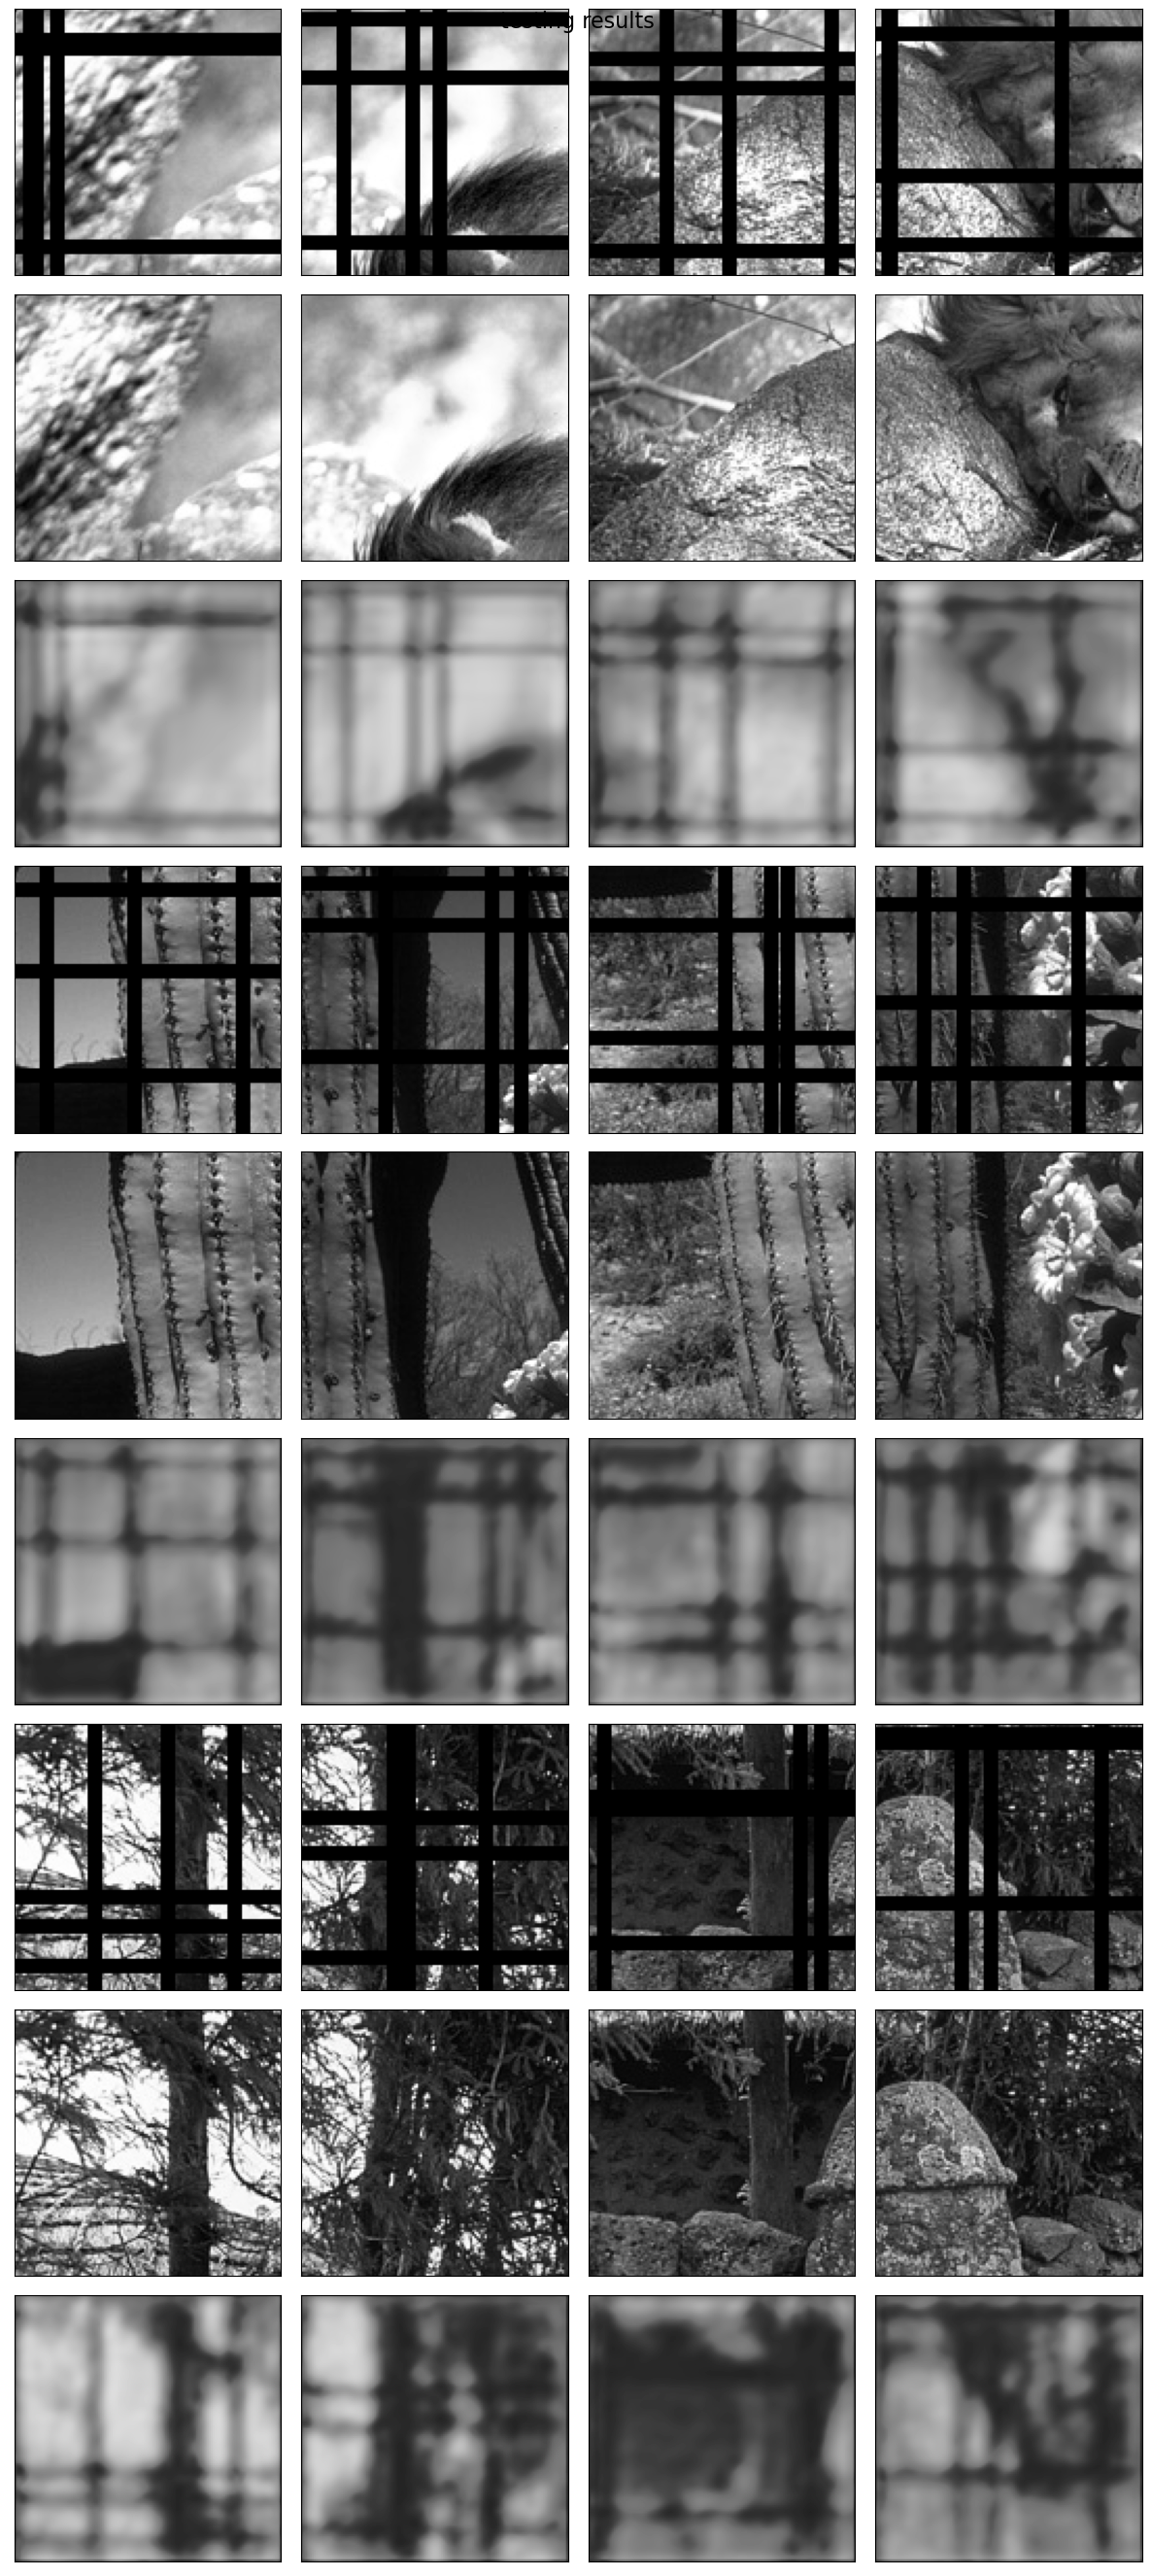


################################################################################
#
# RESULT # 03
#
################################################################################

final testing psnr = 14.64126547


In [264]:
number_result = 3 

for i in range(number_result):

    title           = '# RESULT # {:02d}'.format(i+1)
    name_function   = 'function_result_{:02d}()'.format(i+1)

    print('') 
    print('################################################################################')
    print('#') 
    print(title)
    print('#') 
    print('################################################################################')
    print('') 

    eval(name_function)